In [1]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
time_format = '%d-%m %H:%M:%S'
def extract_startend_times(inputdir, rep, dstat_filename, truncate_sec):
    # create filepath
    filepath = os.path.join(inputdir, str(rep), dstat_filename)
    csv_file = pd.read_csv(filepath, header=3)
    
    start_time = csv_file['time'].min()
    end_time = csv_file['time'].max()
    parsed_start_time = datetime.datetime.strptime(start_time, time_format)
    parsed_end_time = datetime.datetime.strptime(end_time, time_format)
    truncated_start_time = parsed_start_time + datetime.timedelta(0,truncate_sec)
    truncated_end_time = parsed_end_time - datetime.timedelta(0,truncate_sec)
    truncated_start_string = truncated_start_time.strftime(time_format)
    truncated_end_string = truncated_end_time.strftime(time_format)
    return (truncated_start_string, truncated_end_string)

In [3]:
def read_dstat_from_server(experiment_dir, server_dstat_filename, startend_times_tuple):
    start_string = startend_times_tuple[0]
    end_string = startend_times_tuple[1]
    
    filepath = os.path.join(experiment_dir, server_dstat_filename)
    csv_file = pd.read_csv(filepath, header=3)
    
    truncated_data = csv_file[(csv_file['time'] >= start_string) & (csv_file['time'] <= end_string)]
    
    excerp = truncated_data.loc[:, ['idl', 'recv', 'send']]
    means = excerp.mean()
    means['load'] = 100 - means['idl']
    
    return means

In [4]:
def read_server_dstat_all_reps(experiment_dir, reps, client_dstat_filename, server_dstat_filename, truncate_sec):
    rep_time_tuples = [extract_startend_times(inputdir, rep, client_dstat_filename, truncate_sec) for rep in range(1, reps+1)]
    all_reps = [read_dstat_from_server(experiment_dir, server_dstat_filename, tup) for tup in rep_time_tuples]
    result = pd.concat(all_reps, axis='columns').mean(axis='columns')
    return result

In [5]:
def read_server_dstat_all_reps_noavg(experiment_dir, reps, client_dstat_filename, server_dstat_filename, truncate_sec):
    rep_time_tuples = [extract_startend_times(inputdir, rep, client_dstat_filename, truncate_sec) for rep in range(1, reps+1)]
    all_reps = [read_dstat_from_server(experiment_dir, server_dstat_filename, tup) for tup in rep_time_tuples]
    result = pd.concat(all_reps, axis='columns')
    return result

In [6]:
def read_dstat_all_servers(experiment_dir, reps, client_dstat_filename, server_dstat_filenames, truncate_sec):
    all_servers = [read_server_dstat_all_reps(experiment_dir, reps, client_dstat_filename, filename, truncate_sec) for filename in server_dstat_filenames]
    result = pd.concat(all_servers, axis='columns')
    return result

In [7]:
def mean_dstat_servers(data, mean_columns):
    return data.loc[mean_columns, :].mean(axis='columns')

def sum_dstat_servers(data, sum_columns):
    return data.loc[sum_columns, :].sum(axis='columns')

def aggregate_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec):
    data = read_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec)
    means = mean_dstat_servers(data, ['load'])
    sums = sum_dstat_servers(data, ['recv', 'send'])
    return pd.concat([means, sums])

In [30]:
experiment_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_2_multigets_nonsharded_2017-11-24_092308"
sharded = "nonsharded"
#experiment_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912"
#sharded = "sharded"

multigets = [1, 3, 6, 9]

dstat_filename = "client_dstat_01.log"
server_dstat_filenames = ["server_dstat_06.log", "server_dstat_07.log"]
reps = 3
truncate_sec = 5

all_metrics = []
for multiget in multigets:
    inputdir = os.path.join(experiment_dir, "{}_{}multiget".format(sharded, multiget))
    single_metrics = read_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec)
    metrics = aggregate_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec)
    metrics['multigets'] = multiget
    all_metrics.append(metrics)
agg_table = pd.concat(all_metrics, axis=1).transpose()
agg_table['recv'] = agg_table['recv'] / 1000000
agg_table['send'] = agg_table['send'] / 1000000


In [32]:
agg_table

,load,recv,send,multigets
0,16.213876,9.313782,3.569832,1.0
1,17.683824,9.216530,8.925204,3.0
2,18.100713,9.251822,16.696597,6.0
3,18.325403,8.669164,22.591056,9.0


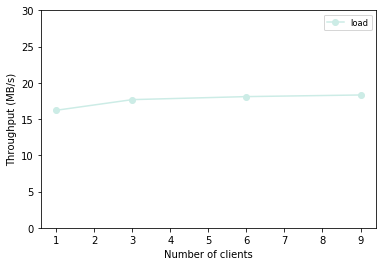

In [31]:

fig, ax = plt.subplots()
color_cycler = cycler('color', ['#ccece6', '#66c2a4', '#238b45', '#00441b'])
ax.set_ylim([0, 30])
#ax.set_xlim([0, 400])
ax.set_prop_cycle(color_cycler)
agg_table.plot(ax=ax, x='multigets', y='load', marker='o')
#plt.xticks(multigets)
ax.legend(loc="best", fontsize="small")
ax.set_xlabel("Number of clients")
ax.set_ylabel("Throughput (MB/s)")

plt.show()

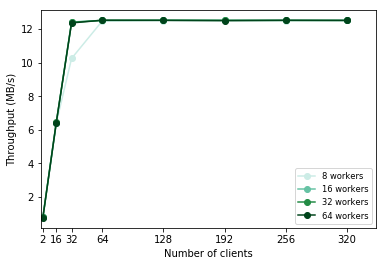

In [52]:
experiment_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp3/3_2_middleware_baseline_twomws_2017-11-26_193516"
workload = "readOnly"
vcs = [1, 8, 16, 32, 64, 96, 128, 160]
workers = [8, 16, 32, 64]
dstat_filename = "client_dstat_01.log"
server_dstat_filenames = ["server_dstat_06.log"]
reps = 3
truncate_sec = 10
num_threads = 2

all_metrics = []
for vc in vcs:
    for worker in workers:
        inputdir = os.path.join(experiment_dir, "{}_{}vc{}workers".format(workload, vc, worker))
        metrics = aggregate_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec)
        metrics['num_clients'] = vc * num_threads
        metrics['workers'] = worker
        all_metrics.append(metrics)
nice_table = pd.concat(all_metrics, axis=1).transpose()
nice_table['recv'] = nice_table['recv'] / 1000000
nice_table['send'] = nice_table['send'] / 1000000

fig, ax = plt.subplots()
color_cycler = cycler('color', ['#ccece6', '#66c2a4', '#238b45', '#00441b'])
#ax.set_ylim([0, 30])
ax.set_xlim([0, 350])
ax.set_prop_cycle(color_cycler)
for key, grp in nice_table.groupby(['workers']):
    grp.plot(ax=ax, x='num_clients', y='send', label="{} workers".format(int(key)), marker='o')
    plt.xticks(grp['num_clients'])
ax.legend(loc="best", fontsize="small")
ax.set_xlabel("Number of clients")
ax.set_ylabel("Throughput (MB/s)")

plt.show()

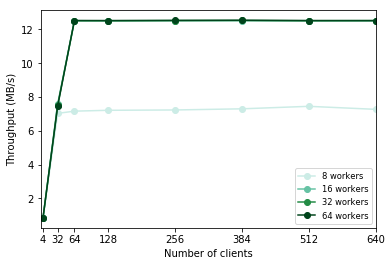

In [53]:
experiment_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp3/3_2_rerun_twomt_2017-11-27_213817"
workload = "readOnly"
vcs = [1, 8, 16, 32, 64, 96, 128, 160]
workers = [8, 16, 32, 64]
dstat_filename = "client_dstat_01.log"
server_dstat_filenames = ["server_dstat_06.log"]
reps = 3
truncate_sec = 10
num_threads = 4

all_metrics = []
for vc in vcs:
    for worker in workers:
        inputdir = os.path.join(experiment_dir, "{}_{}vc{}workers".format(workload, vc, worker))
        metrics = aggregate_dstat_all_servers(experiment_dir, reps, dstat_filename, server_dstat_filenames, truncate_sec)
        metrics['num_clients'] = vc * num_threads
        metrics['workers'] = worker
        all_metrics.append(metrics)
nice_table = pd.concat(all_metrics, axis=1).transpose()
nice_table['recv'] = nice_table['recv'] / 1000000
nice_table['send'] = nice_table['send'] / 1000000

fig, ax = plt.subplots()
color_cycler = cycler('color', ['#ccece6', '#66c2a4', '#238b45', '#00441b'])
#ax.set_ylim([0, 30])
ax.set_xlim([0, 350])
ax.set_prop_cycle(color_cycler)
for key, grp in nice_table.groupby(['workers']):
    grp.plot(ax=ax, x='num_clients', y='send', label="{} workers".format(int(key)), marker='o')
    plt.xticks(grp['num_clients'])
ax.legend(loc="best", fontsize="small")
ax.set_xlabel("Number of clients")
ax.set_ylabel("Throughput (MB/s)")

plt.show()